In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import warnings
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import time

from pynvml.smi import nvidia_smi
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from collections import OrderedDict
from omegaconf import OmegaConf

from monai import transforms
from monai.data import CacheDataset, DataLoader
from monai.config import print_config
from monai.utils import set_determinism, first
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL
from generative.networks.nets.patchgan_discriminator import PatchDiscriminator
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler
import matplotlib.pyplot as plt
import torchvision.transforms as transfor
from monai.apps import MedNISTDataset
import tempfile
from generative.metrics import SSIMMetric, MultiScaleSSIMMetric
from monai import transforms
from monai.config import print_config
from monai.metrics import MAEMetric, PSNRMetric

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data_tcc.zip -d /content/

Archive:  /content/drive/MyDrive/data_tcc.zip
  inflating: /content/data_tcc/Flat_600.700.500_000_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_001_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_002_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_003_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_004_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_005_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_006_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_007_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_008_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_009_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_010_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_011_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.500_012_4-recon-5x2.dcm  
  inflating: /content/data_tcc/Flat_600.700.

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def creating_csvs():
    """
    Função que cria os arquivos .tsv em uma pasta passada pelo argumento
    output_dir. Esses arquivos contêm os caminhos para cada subset (treino, teste
    e validação) das imagens médicas.

    Ao preencher a lista all_data, é necessário adicionar um dicionário para cada
    imagem, permitindo a aplicação de transformações nessas imagens.

    Args:
        args (Namespace): Argumento que contém o caminho parao diretório de
        saída (--output_dir).
    """

    path_data = '/content/data_tcc'
    images_paths = os.listdir(path_data)

    all_data = []
    for image_path in images_paths:
        path_file = os.path.join(path_data, image_path)
        all_data.append({"image": path_file})

    df = pd.DataFrame(all_data)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    train_data_list, test_val_data = train_test_split(df, test_size=0.2, random_state=42)
    val_data_list, test_data_list = train_test_split(test_val_data, test_size=0.5, random_state=42)

    output_dir = '/content'
    os.makedirs(output_dir, exist_ok=True)

    train_data_tsv_path = os.path.join(output_dir, "train.tsv")
    val_data_tsv_path = os.path.join(output_dir, "validation.tsv")
    test_data_tsv_path = os.path.join(output_dir, "test.tsv")

    train_data_list.to_csv(train_data_tsv_path, index=False, sep="\t")
    val_data_list.to_csv(val_data_tsv_path, index=False, sep="\t")
    test_data_list.to_csv(test_data_tsv_path, index=False, sep="\t")

creating_csvs()


In [ ]:
set_determinism(42)

In [ ]:
def get_datalist(ids_path:str):
    """
    Carregamento da tabela dos caminhos para a criação de um vetor com dicionários
    para passar no dataloader específico.

    Args:
        args (str): Caminho do .tsv
    """

    df = pd.read_csv(ids_path, sep="\t")

    data_dicts = []
    for index, row in df.iterrows():
        data_dicts.append(
            {
                "image": str(row["image"]),
            }
        )
    print(f"{len(data_dicts)} imagens.")

    return data_dicts

def get_upsampler_dataloader(batch_size: int,training_ids: str, validation_ids: str, num_workers: int = 8):
    """
    Função que define as transformações das imagens e a criação do dataloader
    do treino e da validação.

    Args:
        batch_size (int): Tamanho do batch
        training_ids (str): Caminho do .tsv de treinamento
        validation_ids (str): Caminho do .tsv de validação
        num_workers (int): Envolve o quão rápido é feito o carregamento dos
        dados na memória (revisar)
    """
    image_size = 256 #*
    low_res_size = 128

    train_transforms = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transforms.ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
            transforms.RandFlipd( #
                keys=["image"],
                spatial_axis=0,
                prob=0.5,
            ),
            transforms.RandAffined(
                keys=["image"],
                rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
                translate_range=[(-1, 1), (-1, 1)],
                scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
                spatial_size=[image_size, image_size], #*
                padding_mode="zeros",
                prob=0.25,
            ),
            transforms.RandShiftIntensityd(keys=["image"], offsets=0.05, prob=0.1), ###
            transforms.RandAdjustContrastd(keys=["image"], gamma=(0.95, 1.05), prob=0.1), ####
            # transforms.ThresholdIntensityd(keys=["image"], threshold=1, above=False, cval=1.0), ####
            # transforms.ThresholdIntensityd(keys=["image"], threshold=0, above=True, cval=0), #####
            transforms.Resized(keys=["image"], spatial_size=(image_size, image_size)),
            transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
            transforms.Resized(keys=["low_res_image"],
                               spatial_size=(low_res_size, low_res_size)),
            transforms.ToTensord(keys=["image", "low_res_image"]),

        ]
    )
    val_transforms = transforms.Compose(
        [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
        transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
        transforms.Resized(keys=["image"], spatial_size=(image_size, image_size)),
        transforms.Resized(keys=["low_res_image"], spatial_size=(low_res_size, low_res_size)),
        transforms.ToTensord(keys=["image", "low_res_image"]),
        ]
    )

    #train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
    #train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]
    train_datalist = get_datalist(ids_path=training_ids)
    train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, persistent_workers=True)

#     check_data = first(train_loader)
#     fig, ax = plt.subplots(nrows=1, ncols=3)
#     for i in range(3):
#         ax[i].imshow(check_data["image"][i, 0, :, :], cmap="gray")
#         ax[i].axis("off")

    #val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
    #val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]

    val_datalist = get_datalist(ids_path=validation_ids)
    val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True,
                            num_workers=num_workers)

    return train_loader, val_loader

In [ ]:
set_determinism(seed=42)
print_config()

output_dir = "/content/runs/"
os.makedirs(output_dir, exist_ok=True)

print("Carregando os dados...")
train_loader, val_loader = get_upsampler_dataloader(
    batch_size=2,
    training_ids='/content/train.tsv',
    validation_ids='/content/validation.tsv',
    num_workers=4,
)

MONAI version: 1.2.0
Numpy version: 1.23.5
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.15.1
gdown version: 4.7.3
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.30.2
mlflow version: 2.10.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

Carregan

Loading dataset:   0%|          | 0/500 [00:00<?, ?it/s]ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
Loading dataset:   1%|          | 6/500 [00:

62 imagens.


Loading dataset:   0%|          | 0/62 [00:00<?, ?it/s]ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
Loading dataset:   6%|▋         | 4/62 [00:00<00:01, 39.03it/s]ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while proces

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


rodar com poucas camadas, dps com 15 e dps com mais e salvar os tempos de treino dos dois modelos

resized das máscaras

### Tempo de treino

- 3 camadas latentes: 41.61 + 96.38 minutos
- 15 camadas latentes: 41.13 + 97.10 minutos / sem data aug: 192.37 minutos aekl   310.85 minutos LDM P100
- 30 camadas latentes: 41.69 101.37 minutos

In [ ]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128),
    latent_channels=15,
    num_res_blocks=2,
    norm_num_groups=32,
    attention_levels=(False, False),
)

autoencoderkl = autoencoderkl.to(device)

discriminator = PatchDiscriminator(spatial_dims=2, in_channels=1, num_layers_d=3, num_channels=64)
discriminator = discriminator.to(device)

In [ ]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.002

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.005

optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=5e-5)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:14<00:00, 16.8MB/s]


In [ ]:
scaler_g = GradScaler()
scaler_d = GradScaler()

## Train Autoencoder

Epoch 9: 100%|█████████████████| 250/250 [00:28<00:00,  8.68it/s, recons_loss=0.0231, gen_loss=0, disc_loss=0]


epoch 10 val loss: 0.0298


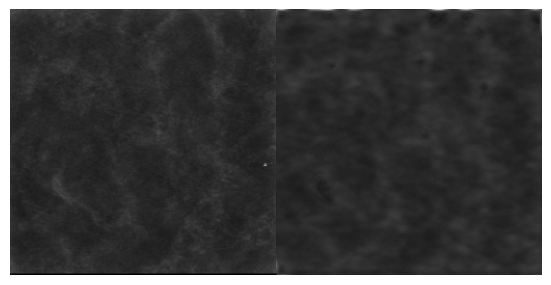

Epoch 19: 100%|████████| 250/250 [00:32<00:00,  7.59it/s, recons_loss=0.0215, gen_loss=0.302, disc_loss=0.241]


epoch 20 val loss: 0.0367


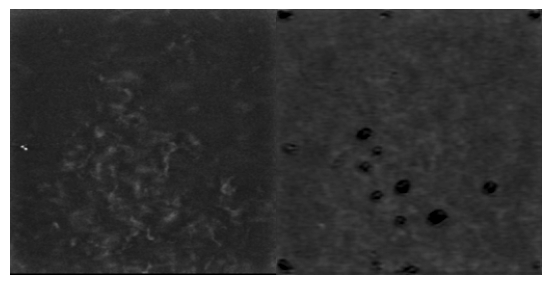

Epoch 29: 100%|███████| 250/250 [00:33<00:00,  7.57it/s, recons_loss=0.0195, gen_loss=0.826, disc_loss=0.0625]


epoch 30 val loss: 0.0264


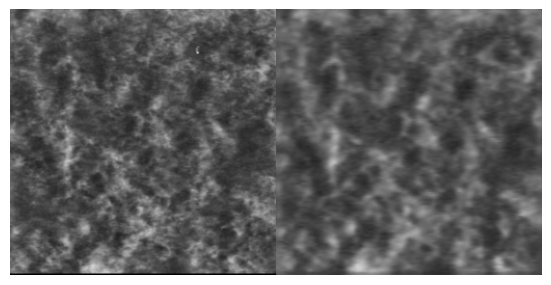

Epoch 39: 100%|███████| 250/250 [00:33<00:00,  7.55it/s, recons_loss=0.0182, gen_loss=0.882, disc_loss=0.0596]


epoch 40 val loss: 0.0249


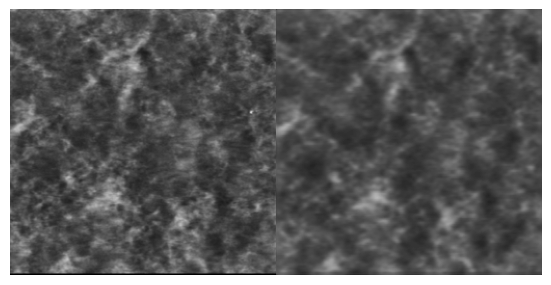

Epoch 49: 100%|████████| 250/250 [00:33<00:00,  7.49it/s, recons_loss=0.0167, gen_loss=0.896, disc_loss=0.047]


epoch 50 val loss: 0.0261


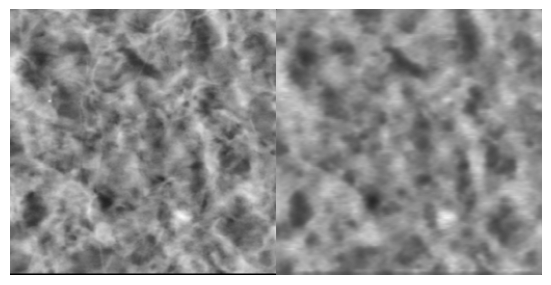

Epoch 59: 100%|████████| 250/250 [00:33<00:00,  7.47it/s, recons_loss=0.0154, gen_loss=0.891, disc_loss=0.049]


epoch 60 val loss: 0.0230


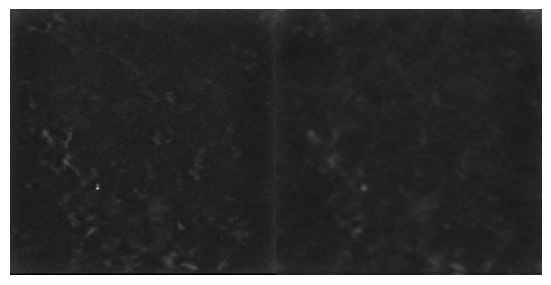

Epoch 69: 100%|███████| 250/250 [00:33<00:00,  7.49it/s, recons_loss=0.0148, gen_loss=0.902, disc_loss=0.0431]


epoch 70 val loss: 0.0238


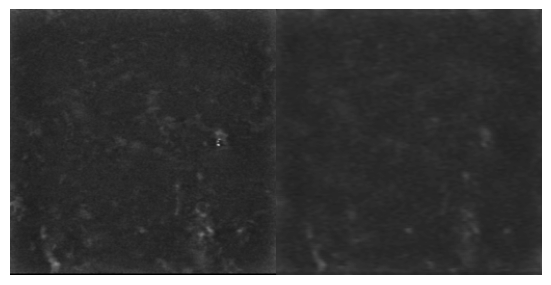

Epoch 74: 100%|█████████| 250/250 [00:33<00:00,  7.50it/s, recons_loss=0.015, gen_loss=0.936, disc_loss=0.032]


In [ ]:
kl_weight = 1e-6
n_epochs = 75
val_interval = 10
autoencoder_warm_up_n_epochs = 10
raw_model = autoencoderkl.module if hasattr(autoencoderkl, "module") else autoencoderkl
start_time = time.time()

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            optimizer_d.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                reconstruction, z_mu, z_sigma = autoencoderkl(images)
                recons_loss = F.l1_loss(images.float(), reconstruction.float())
                val_loss += recons_loss.item()

        val_loss /= val_step
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")

        plt.figure(figsize=(6,6))
        plt.imshow(torch.cat([images[0, 0].cpu(), reconstruction[0, 0].cpu()], dim=1), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

progress_bar.close()
end_time = time.time()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

In [ ]:
elapsed_time_minutes = (end_time - start_time) / 60.0
print(f"Tempo de execução: {elapsed_time_minutes:.2f} minutos")

Tempo de execução: 41.13 minutos


In [ ]:
import os
torch.save(raw_model.state_dict(), '/content/drive/MyDrive/tcc_models/2_training/final_model_aekl.pth')

In [ ]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128),
    latent_channels=15,
    num_res_blocks=2,
    norm_num_groups=32,
    attention_levels=(False, False),
)

autoencoderkl.load_state_dict(torch.load('/content/final_model_aekl_15camadas_codigotutorial.pth'))
autoencoderkl.to(device);

In [ ]:
check_data = first(train_loader)

with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.9947134852409363


In [ ]:
set_determinism(seed=42)
print_config()

output_dir = "/content/runs/"
os.makedirs(output_dir, exist_ok=True)

print("Carregando os dados...")
train_loader, val_loader = get_upsampler_dataloader(
    batch_size=1,
    training_ids='/content/train.tsv',
    validation_ids='/content/validation.tsv',
    num_workers=4,
)

MONAI version: 1.2.0
Numpy version: 1.23.5
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.15.1
gdown version: 4.7.3
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.30.2
mlflow version: 2.10.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

Carregan

Loading dataset:   0%|          | 0/500 [00:00<?, ?it/s]ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 000

62 imagens.


Loading dataset:   0%|          | 0/62 [00:00<?, ?it/s]ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
Loading dataset:   8%|▊         | 5/62 [00:00<00:01, 43.20it/s]ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while proces

In [ ]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=16,
    out_channels=15,
    num_res_blocks=2,
    num_channels=(256, 256),
    attention_levels=(False, True),
    num_head_channels=( 0, 64),
)

unet = unet.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

In [ ]:
low_res_scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)
max_noise_level = 350

Epoch 19: 100%|██████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.21it/s, loss=0.23]


Epoch 19 val loss: 0.2088


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.85it/s]


PSNR: 23.358978271484375	MAE: 0.05558948218822479
SSIM: 0.6647041440010071	MSSIM: 0.5477520227432251


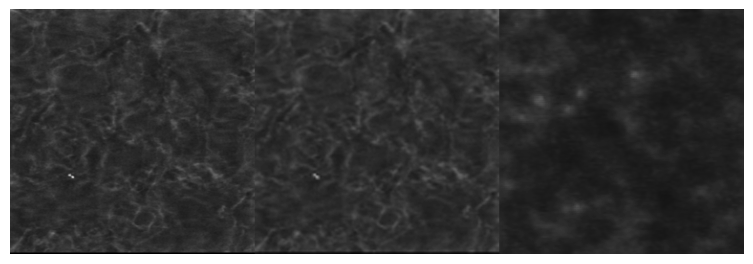

Epoch 39: 100%|██████████████████████████████████████████████████| 500/500 [00:45<00:00, 11.00it/s, loss=0.23]


Epoch 39 val loss: 0.1944


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.63it/s]


PSNR: 25.729969024658203	MAE: 0.03891459107398987
SSIM: 0.7481241226196289	MSSIM: 0.6499245762825012


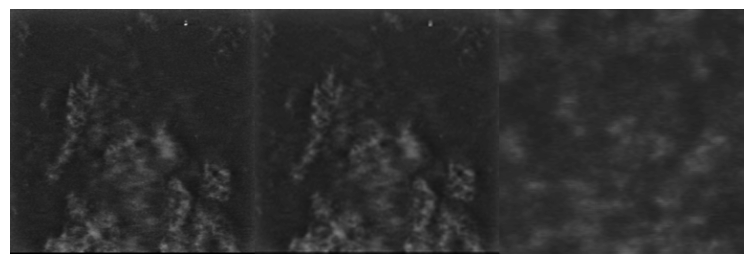

Epoch 59: 100%|█████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.98it/s, loss=0.223]


Epoch 59 val loss: 0.2443


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.66it/s]


PSNR: 26.684982299804688	MAE: 0.033083751797676086
SSIM: 0.7435543537139893	MSSIM: 0.6770645976066589


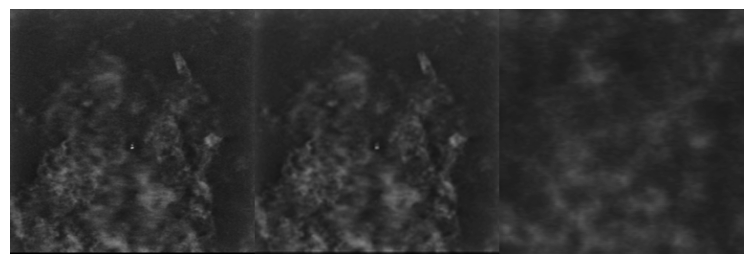

Epoch 79: 100%|█████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.95it/s, loss=0.213]


Epoch 79 val loss: 0.1857


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.65it/s]


PSNR: 20.396211624145508	MAE: 0.08175400644540787
SSIM: 0.5619128942489624	MSSIM: 0.6140174865722656


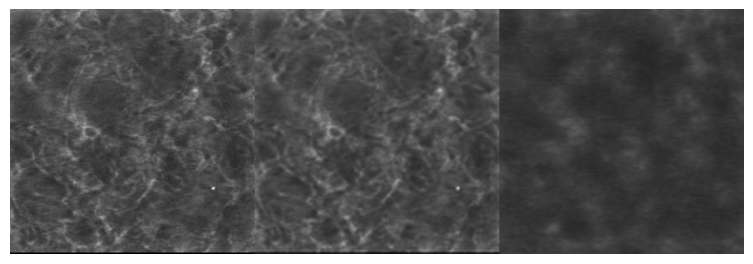

Epoch 99: 100%|█████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.91it/s, loss=0.232]


Epoch 99 val loss: 0.1825


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.64it/s]


PSNR: 21.462738037109375	MAE: 0.06464063376188278
SSIM: 0.5604908466339111	MSSIM: 0.6458210349082947


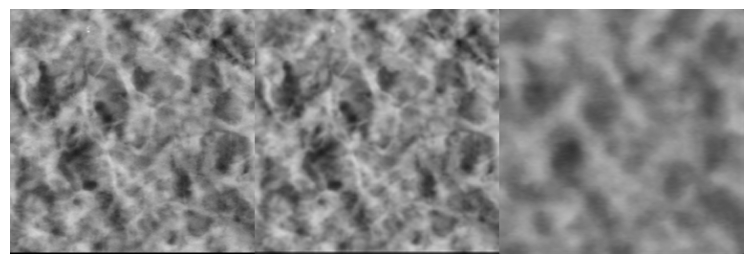

Epoch 119: 100%|████████████████████████████████████████████████| 500/500 [00:45<00:00, 10.88it/s, loss=0.217]


Epoch 119 val loss: 0.2209


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.56it/s]


PSNR: 23.98751449584961	MAE: 0.04887337237596512
SSIM: 0.7054623961448669	MSSIM: 0.718669056892395


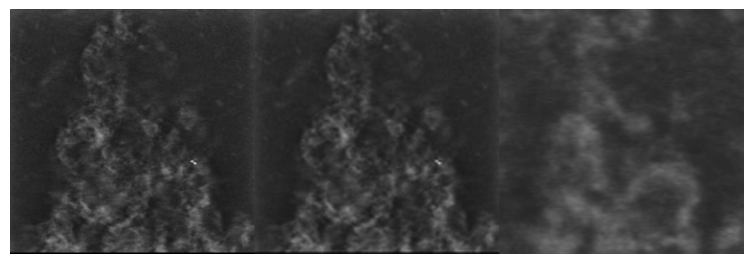

In [ ]:
optimizer = torch.optim.Adam(unet.parameters(), lr=5e-5)

scaler_diffusion = GradScaler()
psnr_metric = PSNRMetric(max_val=1.0)
mae_metric = MAEMetric()
mssim_metric = MultiScaleSSIMMetric(spatial_dims=2, kernel_size=7)
ssim_metric = SSIMMetric(spatial_dims=2, kernel_size=7)

n_epochs = 120
val_interval = 20
epoch_loss_list = []
val_epoch_loss_list = []
start_time = time.time()

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        low_res_image = batch["low_res_image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            with torch.no_grad():
                latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor

            noise = torch.randn_like(latent).to(device)
            low_res_noise = torch.randn_like(low_res_image).to(device)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device).long()
            low_res_timesteps = torch.randint(
                0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
            ).long()

            noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
            noisy_low_res_image = low_res_scheduler.add_noise(
                original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
            )

            latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)

            noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler_diffusion.scale(loss).backward()
        scaler_diffusion.step(optimizer)
        scaler_diffusion.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        for val_step, batch in enumerate(val_loader, start=1):
            images = batch["image"].to(device)
            low_res_image = batch["low_res_image"].to(device)

            with torch.no_grad():
                with autocast(enabled=True):
                    latent = autoencoderkl.encode_stage_2_inputs(images) * scale_factor

                    noise = torch.randn_like(latent).to(device)
                    low_res_noise = torch.randn_like(low_res_image).to(device)
                    timesteps = torch.randint(
                        0, scheduler.num_train_timesteps, (latent.shape[0],), device=latent.device
                    ).long()
                    low_res_timesteps = torch.randint(
                        0, max_noise_level, (low_res_image.shape[0],), device=low_res_image.device
                    ).long()

                    noisy_latent = scheduler.add_noise(original_samples=latent, noise=noise, timesteps=timesteps)
                    noisy_low_res_image = low_res_scheduler.add_noise(
                        original_samples=low_res_image, noise=low_res_noise, timesteps=low_res_timesteps
                    )

                    latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)
                    noise_pred = unet(x=latent_model_input, timesteps=timesteps, class_labels=low_res_timesteps)
                    loss = F.mse_loss(noise_pred.float(), noise.float())

            val_loss += loss.item()
        val_loss /= val_step
        val_epoch_loss_list.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        #colocar as métricas nessa parte
        sampling_image = low_res_image[0].unsqueeze(0)
        latents = torch.randn((1, 15, 128, 128)).to(device)
        low_res_noise = torch.randn((1, 1, 128, 128)).to(device)
        noise_level = 1
        noise_level = torch.Tensor((noise_level,)).long().to(device)
        noisy_low_res_image = low_res_scheduler.add_noise(
            original_samples=sampling_image,
            noise=low_res_noise,
            timesteps=torch.Tensor((noise_level,)).long().to(device),
        )

        scheduler.set_timesteps(num_inference_steps=1000)
        for t in tqdm(scheduler.timesteps, ncols=110):
            with torch.no_grad():
                with autocast(enabled=True):
                    latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
                    noise_pred = unet(
                        x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level
                    )
                latents, _ = scheduler.step(noise_pred, t, latents)

        with torch.no_grad():
            decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

        psnr_value = psnr_metric(images, decoded)
        mae_value = mae_metric(images, decoded)
        mssim_value = mssim_metric(images, decoded)
        ssim_value = ssim_metric(images, decoded)

        print(f'PSNR: {psnr_value.item()}\tMAE: {mae_value.item()}\nSSIM: {ssim_value.item()}\tMSSIM: {mssim_value.item()}')

        low_res_bicubic = nn.functional.interpolate(sampling_image, (256, 256), mode="bicubic")
        plt.figure(figsize=(8,8))
        plt.style.use("default")
        plt.imshow(
            torch.cat([images[0, 0].cpu(), low_res_bicubic[0, 0].cpu(), decoded[0, 0].cpu()], dim=1),
            vmin=0,
            vmax=1,
            cmap="gray",
        )
        plt.tight_layout()
        plt.axis("off")
        plt.show()

end_time = time.time()

In [ ]:
elapsed_time_minutes = (end_time - start_time) / 60.0
print(f"Tempo de execução: {elapsed_time_minutes:.2f} minutos")

Tempo de execução: 97.10 minutos


In [ ]:
torch.save(unet.state_dict(), '/content/drive/MyDrive/tcc_models/2_training/final_model_ldm.pth')

In [ ]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128),
    latent_channels=15,
    num_res_blocks=2,
    norm_num_groups=32,
    attention_levels=(False, False),
)

autoencoderkl.load_state_dict(torch.load('/content/final_model_aekl_15camadas_codigotutorial.pth'))
autoencoderkl.to(device);

In [ ]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

NameError: ignored

In [ ]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=16,
    out_channels=15,
    num_res_blocks=2,
    num_channels=(256, 512),
    attention_levels=(False, True),
    num_head_channels=( 0, 256),
)


unet.load_state_dict(torch.load('/content/drive/My Drive/final_model_ldm_15camadas_codigotutorial.pth'))
unet = unet.to(device);

In [ ]:
from torchinfo import summary

summary(model = unet)

Layer (type:depth-idx)                        Param #
DiffusionModelUNet                            --
├─Convolution: 1-1                            --
│    └─Conv2d: 2-1                            37,120
├─Sequential: 1-2                             --
│    └─Linear: 2-2                            263,168
│    └─SiLU: 2-3                              --
│    └─Linear: 2-4                            1,049,600
├─ModuleList: 1-3                             --
│    └─DownBlock: 2-5                         --
│    │    └─ModuleList: 3-1                   2,887,168
│    │    └─Downsample: 3-2                   590,080
│    └─AttnDownBlock: 2-6                     --
│    │    └─ModuleList: 3-3                   2,103,296
│    │    └─ModuleList: 3-4                   9,444,352
├─AttnMidBlock: 1-4                           --
│    └─ResnetBlock: 2-7                       --
│    │    └─GroupNorm: 3-5                    1,024
│    │    └─SiLU: 3-6                         --
│    │    └─Convolu

In [ ]:
val_transforms = transforms.Compose(
  [
  transforms.LoadImaged(keys=["image"], reader="PILReader"),
  transforms.EnsureChannelFirstd(keys=["image"]),
  transforms.ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
  transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
  transforms.Resized(keys=["image"], spatial_size=(256, 256)),
  transforms.Resized(keys=["low_res_image"], spatial_size=(128, 128)),
  transforms.ToTensord(keys=["image", "low_res_image"]),
  ]
)

val_datalist = get_datalist(ids_path='/content/validation.tsv')
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=5, shuffle=True,
                      num_workers=4)


5 imagens.


Loading dataset:   0%|          | 0/5 [00:00<?, ?it/s]ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
Loading dataset:  20%|██        | 1/5 [00:00<00:00,  8.47it/s]ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
ERROR:pydicom:Error while processing tag 00081155
ERROR:pydicom:Error while processing tag 00082112
ERROR:pydicom:Error while processing tag 00204000
Loading dataset: 100%|██████████| 5/5 [00:00<00:00, 22.19it/s]


In [ ]:
unet.eval()
num_samples = 5
validation_batch = first(val_loader)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)
images = validation_batch["image"].to(device)
sampling_image = validation_batch["low_res_image"].to(device)[:num_samples]

In [ ]:
latents = torch.randn((num_samples, 15, 128, 128)).to(device)
low_res_noise = torch.randn((num_samples, 1, 128, 128)).to(device)
noise_level = 1
noise_level = torch.Tensor((noise_level,)).long().to(device)
noisy_low_res_image = scheduler.add_noise(
    original_samples=sampling_image, noise=low_res_noise, timesteps=torch.Tensor((noise_level,)).long().to(device)
)
scheduler.set_timesteps(num_inference_steps=1000)
for t in tqdm(scheduler.timesteps, ncols=110):
    with torch.no_grad():
        with autocast(enabled=True):
            latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
            noise_pred = unet(x=latent_model_input, timesteps=torch.Tensor((t,)).to(device), class_labels=noise_level)

        latents, _ = scheduler.step(noise_pred, t, latents)

with torch.no_grad():
    decoded = autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [07:02<00:00,  2.37it/s]


In [ ]:
psnr_metric = PSNRMetric(max_val=1.0)
mae_metric = MAEMetric()
mssim_metric = MultiScaleSSIMMetric(spatial_dims=2, kernel_size=7)
ssim_metric = SSIMMetric(spatial_dims=2, kernel_size=7)

psnr_value = psnr_metric(images, decoded)
mae_value = mae_metric(images, decoded)
mssim_value = mssim_metric(images, decoded)
ssim_value = ssim_metric(images, decoded)


In [ ]:
for i in range(num_samples):
  print(f'PSNR: {psnr_value[i].item()}\tMAE: {mae_value[i].item()}\nSSIM: {ssim_value[i].item()}\tMSSIM: {mssim_value[i].item()}')
  print('')

PSNR: 27.79230499267578	MAE: 0.03227866441011429
SSIM: 0.684299886226654	MSSIM: 0.6655619740486145

PSNR: 21.033803939819336	MAE: 0.07342980802059174
SSIM: 0.6100103855133057	MSSIM: 0.8098867535591125

PSNR: 24.901966094970703	MAE: 0.040619902312755585
SSIM: 0.5945523977279663	MSSIM: 0.7396081686019897

PSNR: 26.17908477783203	MAE: 0.03826744109392166
SSIM: 0.6714851260185242	MSSIM: 0.7637948989868164

PSNR: 25.13039779663086	MAE: 0.04493376240134239
SSIM: 0.687297523021698	MSSIM: 0.7319615483283997



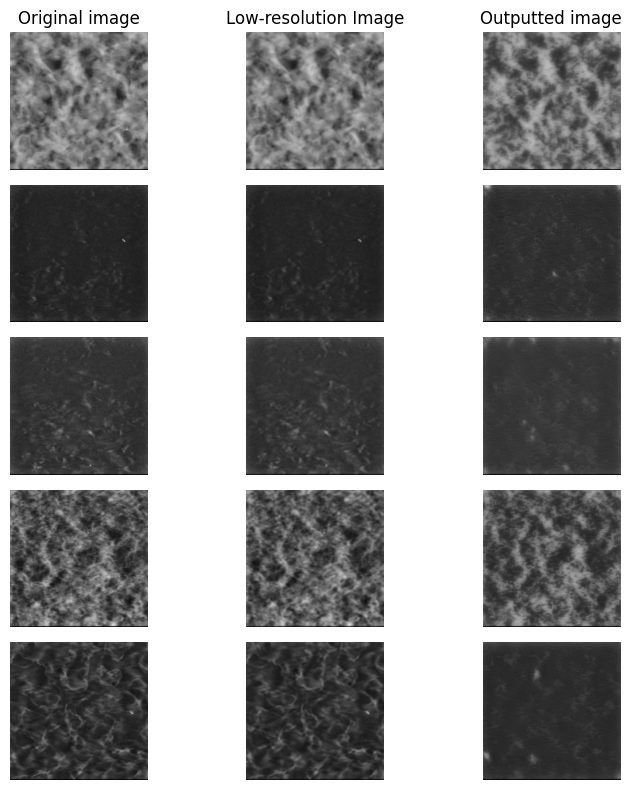

In [ ]:
low_res_bicubic = nn.functional.interpolate(sampling_image, (256, 256), mode="bicubic")
fig, axs = plt.subplots(num_samples, 3, figsize=(8, 8))
axs[0, 0].set_title("Original image")
axs[0, 1].set_title("Low-resolution Image")
axs[0, 2].set_title("Outputted image")

for i in range(0, num_samples):
    axs[i, 0].imshow(images[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(low_res_bicubic[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 1].axis("off")
    axs[i, 2].imshow(decoded[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 2].axis("off")

plt.tight_layout()